## Load data

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
def load_and_normalize_data(X_path: str, y_path: str, numSamples=None):
    X = pd.read_csv(X_path)
    y = pd.read_csv(y_path)

    if numSamples is not None:
        X = X.sample(n=numSamples, random_state=42)
        y = y.loc[X.index]

    # Initialize scalers
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    # Normalize features (X)
    X_normalized = feature_scaler.fit_transform(X)

    # Normalize target (y)
    y_normalized = target_scaler.fit_transform(y).ravel()

    return X_normalized, y_normalized
#Load data from Google Drive
from google.colab import drive

drive.mount('/content/drive')

# Specify the file paths for your x.csv and y.csv
x_path = '/content/drive/MyDrive/rex09/x.csv'
y_path = '/content/drive/MyDrive/rex09/y.csv'
X, y = load_and_normalize_data(x_path, y_path, numSamples=10000000) # 如果要跑全部資料的話把numSamples參數刪掉

Mounted at /content/drive


In [3]:
def split_data(X: pd.DataFrame, y: np.ndarray, test_size: float = 0.2, random_state: int = 42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

X_train, X_test, y_train, y_test = split_data(X, y)

In [4]:
numFeatures = X_train.shape[1]
print(f"Number of features: {numFeatures}")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Number of features: 13
Shape of X_train: (8000000, 13)
Shape of y_train: (8000000,)
Shape of X_test: (2000000, 13)
Shape of y_test: (2000000,)


## Model

In [5]:
from tensorflow import keras
from tensorflow.keras import layers, models

In [6]:
def create_model(hps):
    model = models.Sequential([
        layers.Input(shape=(numFeatures,)),
        layers.Dense(hps['units1'], activation='relu'),
        layers.Dense(hps['units2'], activation='relu'),
        layers.Dense(1)
    ])

    return model

In [7]:
hps = {
    'units1': 256,
    'units2': 128,
    'learning_rate': 0.001,
    'epochs': 100,
}

In [8]:
def train(X_train, y_train, hps):
    model = create_model(hps)
    optimizer = keras.optimizers.Adam(learning_rate=hps.get('learning_rate'))
    model.compile(optimizer=optimizer, loss='mse')

    history = model.fit(X_train, y_train, epochs=hps.get('epochs'), validation_split=0.2)

    return model, history

model, history = train(X_train, y_train, hps)

Epoch 1/100
200000/200000 ━━━━━━━━━━━━━━━━━━━━ 282s 1ms/step - loss: 0.0119 - val_loss: 0.0075
Epoch 2/100
200000/200000 ━━━━━━━━━━━━━━━━━━━━ 278s 1ms/step - loss: 0.0075 - val_loss: 0.0071
Epoch 3/100
200000/200000 ━━━━━━━━━━━━━━━━━━━━ 279s 1ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 4/100
200000/200000 ━━━━━━━━━━━━━━━━━━━━ 279s 1ms/step - loss: 0.0064 - val_loss: 0.0060
Epoch 5/100
200000/200000 ━━━━━━━━━━━━━━━━━━━━ 280s 1ms/step - loss: 0.0062 - val_loss: 0.0064
Epoch 6/100
200000/200000 ━━━━━━━━━━━━━━━━━━━━ 281s 1ms/step - loss: 0.0062 - val_loss: 0.0062
Epoch 7/100
200000/200000 ━━━━━━━━━━━━━━━━━━━━ 281s 1ms/step - loss: 0.0061 - val_loss: 0.0062
Epoch 8/100
200000/200000 ━━━━━━━━━━━━━━━━━━━━ 281s 1ms/step - loss: 0.0061 - val_loss: 0.0065
Epoch 9/100
200000/200000 ━━━━━━━━━━━━━━━━━━━━ 281s 1ms/step - loss: 0.0060 - val_loss: 0.0062
Epoch 10/100
200000/200000 ━━━━━━━━━━━━━━━━━━━━ 281s 1ms/step - loss: 0.0059 - val_loss: 0.0060
Epoch 11/100
200000/200000 ━━━━━━━━━━━━━━━━━━━━ 2

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

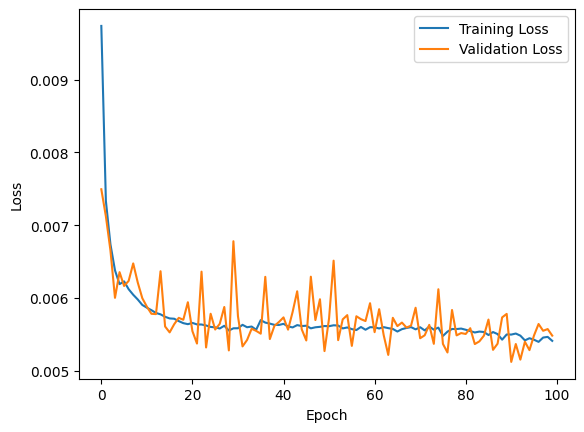

In [10]:
def visualize_training_and_validation_curves(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

visualize_training_and_validation_curves(history)

## Test

In [11]:
def model_predict(model, X_train, X_test, y_train, y_test):
    """
    Evaluate model performance on train and test sets.

    Args:
        model: Trained model
        X_train: Training features
        X_test: Testing features
        y_train: Training targets
        y_test: Testing targets

    Returns:
        Dictionary containing performance metrics
    """
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    metrics = {
        'train_mse': mean_squared_error(y_train, y_train_pred),
        'test_mse': mean_squared_error(y_test, y_test_pred),
        'train_r2': r2_score(y_train, y_train_pred),
        'test_r2': r2_score(y_test, y_test_pred),
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred
    }

    for metric, value in metrics.items():
        if isinstance(value, float):
            print(f"{metric}: {value:.4f}")

    return metrics

metrics = model_predict(model, X_train, X_test, y_train, y_test)

250000/250000 ━━━━━━━━━━━━━━━━━━━━ 257s 1ms/step
62500/62500 ━━━━━━━━━━━━━━━━━━━━ 64s 1ms/step
train_mse: 0.0055
test_mse: 0.0055
train_r2: 0.6352
test_r2: 0.6353


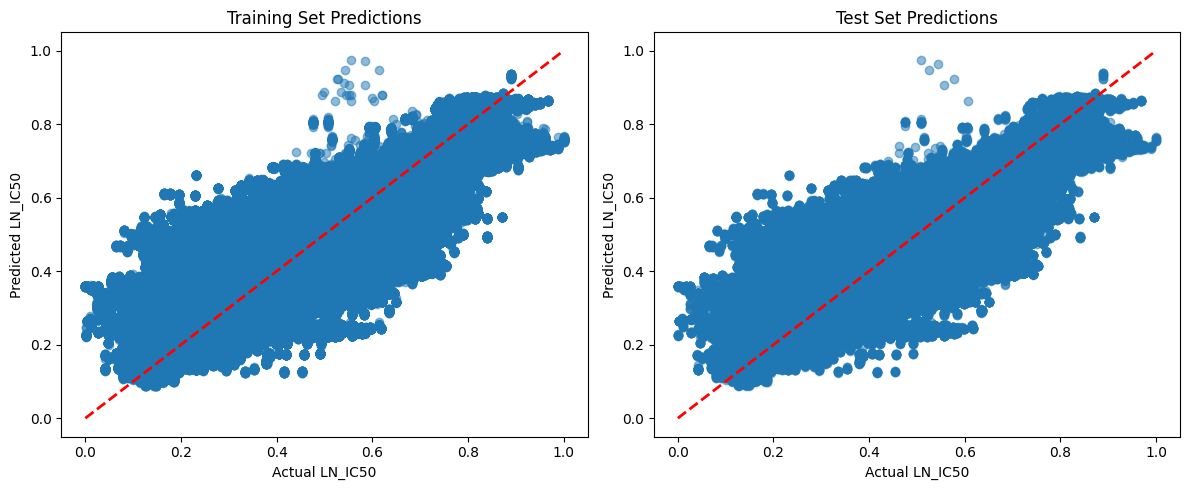

In [12]:
def plot_predictions(y_train: np.ndarray, y_test: np.ndarray,
                    y_train_pred: np.ndarray, y_test_pred: np.ndarray):
    """
    Visualize model predictions.

    Args:
        y_train: Actual training targets
        y_test: Actual testing targets
        y_train_pred: Predicted training targets
        y_test_pred: Predicted testing targets
    """
    plt.figure(figsize=(12, 5))

    # Training set predictions
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, alpha=0.5)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
    plt.xlabel('Actual LN_IC50')
    plt.ylabel('Predicted LN_IC50')
    plt.title('Training Set Predictions')

    # Test set predictions
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual LN_IC50')
    plt.ylabel('Predicted LN_IC50')
    plt.title('Test Set Predictions')

    plt.tight_layout()
    plt.show()

plot_predictions(y_train, y_test, metrics['y_train_pred'], metrics['y_test_pred'])